In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean

In [2]:
def read_accuracy_file(synthesis_results_file, format, clock):
    lines = []
    with open(synthesis_results_file) as screen_outputs:
        lines = screen_outputs.readlines()

    # Obtain resources
    resources = dict.fromkeys(
        ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Frequency', 'Cycles'], 0)
    clock = str(clock)
    read = False
    for line in lines:
        if (format in line) and (clock in line):
            read = True
        elif '---' in line:
            read = False
        if read:
            if line[:3] == "LUT":
                resources['LUTs'] = (int(line[6:-1]))
            elif line[:2] == "FF":
                resources['FFs'] = (int(line[5:-1]))
            elif line[:3] == "DSP":
                resources['DSPs'] = (int(line[6:-1]))
            elif line[:8] == "BRAM_18K":
                resources['BRAMs'] = (int(line[11:-1]))
            elif line[:17] == "Clock Period (ns)":
                resources['Frequency'] = (1000/float(line[20:-1]))
            elif line[:16] == "Latency (cycles)":
                resources['Cycles'] = (int(line[19:-1]))

    return resources

In [3]:
# https://stackoverflow.com/questions/22104256/does-matplotlib-have-a-function-for-drawing-diagonal-lines-in-axis-coordinates
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)

    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [4]:
def plot_results(benchmark_name, all=False):
    fig, axs = plt.subplots(nrows=2,
                            ncols=2+all,
                            figsize=(10, 6))

    # colors = ['#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c']
    colors = (mpl.colormaps['tab10']).colors

    # formats = ['float32', 'posit32',
    #            'float64', 'posit64']
    formats = ['float32', 'float64',
               'posit32', 'posit64']

    for i, format in enumerate(formats):
        luts_list = []
        ffs_list = []
        dsps_list = []
        brams_list = []
        frequency_list = []
        cycles_list = []
        target_list = []

        # for period in [20, 10, 6.66667, 5, 4, 3.3333]:
        for period in [20, 10, 6.66667, ]:  # 5, 4, 3.3333]:
            # for period in [20, 10, 6.6667, 5, 4, 3.333]:
            # df = read_accuracy_file(
            #     '../Vitis_HLS/' + benchmark_name + '/' + format + '/results_' + str(period) + '.txt')
            df = read_accuracy_file(
                '../Vitis_HLS/polybench/' + benchmark_name + '/results.txt', format, period)

            luts_list.append(df['LUTs'])
            ffs_list.append(df['FFs'])
            dsps_list.append(df['DSPs'])
            brams_list.append(df['BRAMs'])
            frequency_list.append(df['Frequency'])
            cycles_list.append(df['Cycles'])
            target_list.append(round(1000/period))

        # plot
        axs[0, 0].plot(target_list, luts_list, label=format, color=colors[i])
        axs[0, 1].plot(target_list, ffs_list, label=format, color=colors[i])
        axs[1, 0].plot(target_list, frequency_list,
                       label=format, color=colors[i])
        axs[1, 1].plot(target_list, cycles_list, label=format, color=colors[i])
        if (all):
            axs[0, 2].plot(target_list, dsps_list,
                           label=format, color=colors[i])
            axs[1, 2].plot(target_list, brams_list,
                           label=format, color=colors[i])

    # Labels
    axs[0, 0].set_ylabel('LUTs')
    axs[0, 1].set_ylabel('FFs')
    axs[1, 0].set_ylabel('Max Frequency (MHz)')
    axs[1, 1].set_ylabel('Latency (cycles)')
    axs[1, 0].set_xlabel('Target Frequency (MHz)')
    axs[1, 1].set_xlabel('Target Frequency (MHz)')
    if (all):
        axs[0, 2].set_ylabel('DSPs')
        axs[1, 2].set_ylabel('BRAMs')
        axs[1, 2].set_xlabel('Target Frequency (MHz)')

    # Grid
    axs[0, 0].grid(zorder=0, )  # axis='y')
    axs[0, 1].grid(zorder=0, )  # axis='y')
    axs[1, 0].grid(zorder=0, )  # axis='y')
    axs[1, 1].grid(zorder=0, )  # axis='y')
    if (all):
        axs[0, 2].grid(zorder=0, )  # axis='y')
        axs[1, 2].grid(zorder=0, )  # axis='y')
    for ax in np.ravel(axs):
        ax.set_xticks(target_list)

    # Show target frequencies
    add_identity(axs[1, 0],
                 color='tab:gray',
                 linestyle='--',
                 linewidth=1,
                 zorder=0)

    # Adjust the spacing between the subplots
    fig.tight_layout()

    # Create a legend object for all subplots
    fig.legend(list(map(str.title, formats)), title='Format',
               loc='upper center', bbox_to_anchor=(0.5, 1.08),
               ncol=len(formats))

    # plt.savefig(benchmark_name+'_synthesis.pdf', bbox_inches='tight')

    plt.show()

## Individual benchmarks

### GEMM

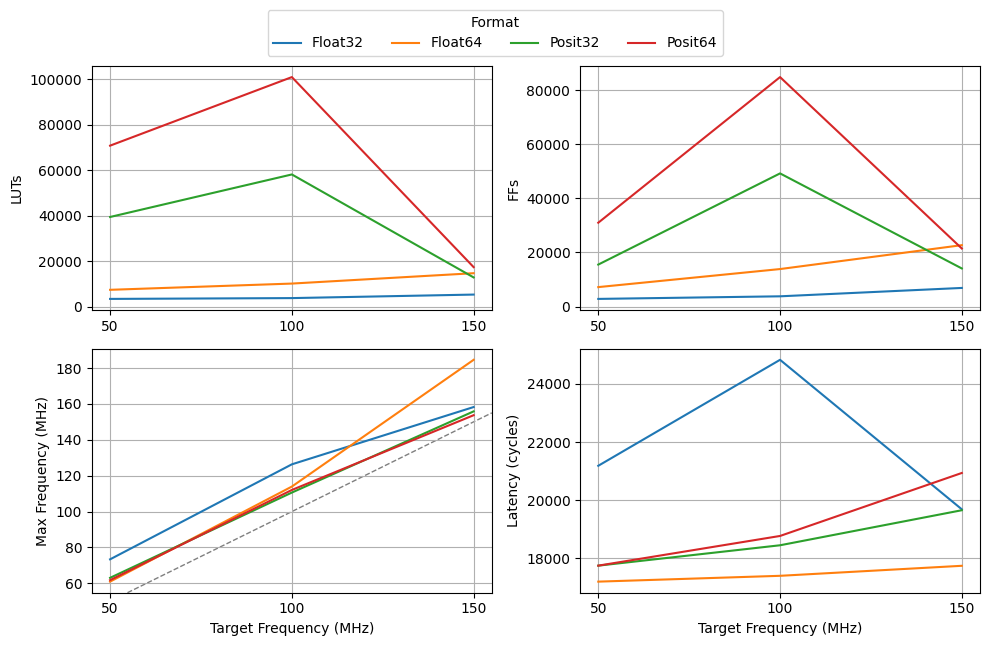

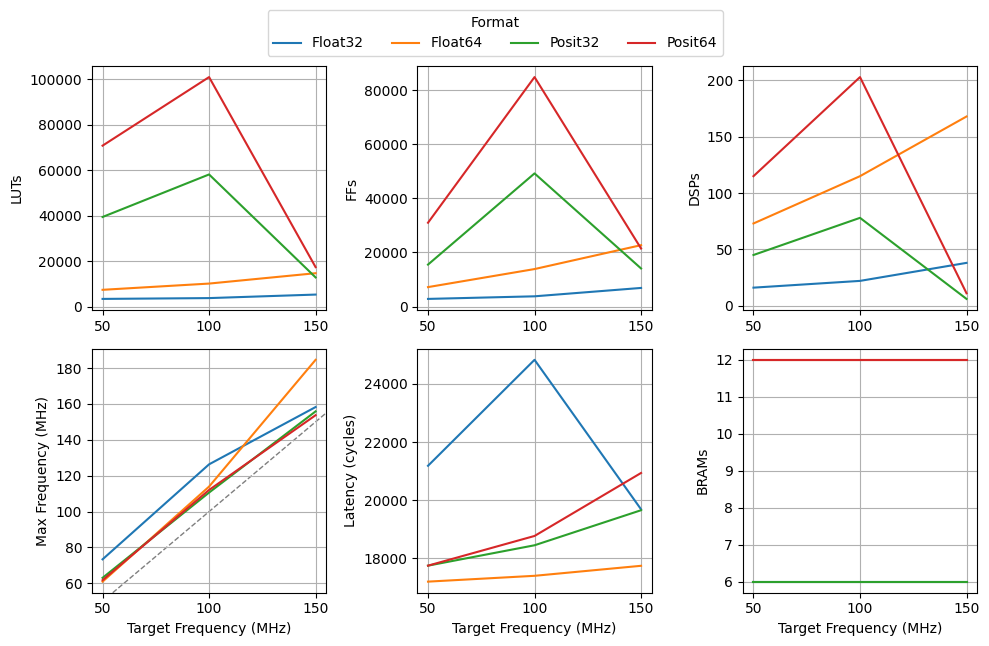

In [5]:
benchmark_name = 'gemm'

plot_results(benchmark_name)
plot_results(benchmark_name, all=True)
# plot_results_all(benchmark_name)

### 3mm

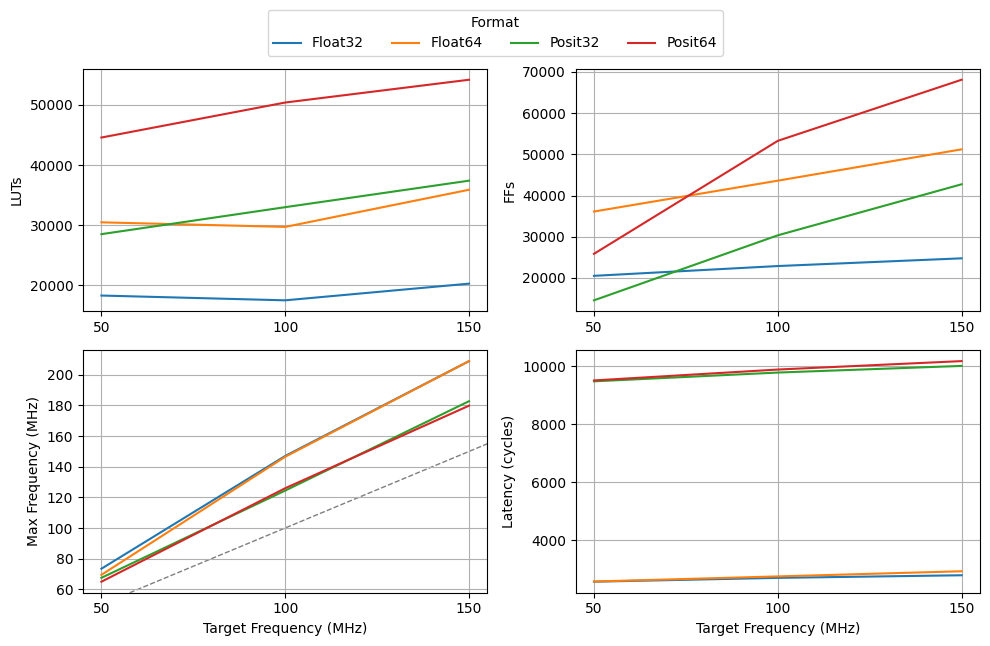

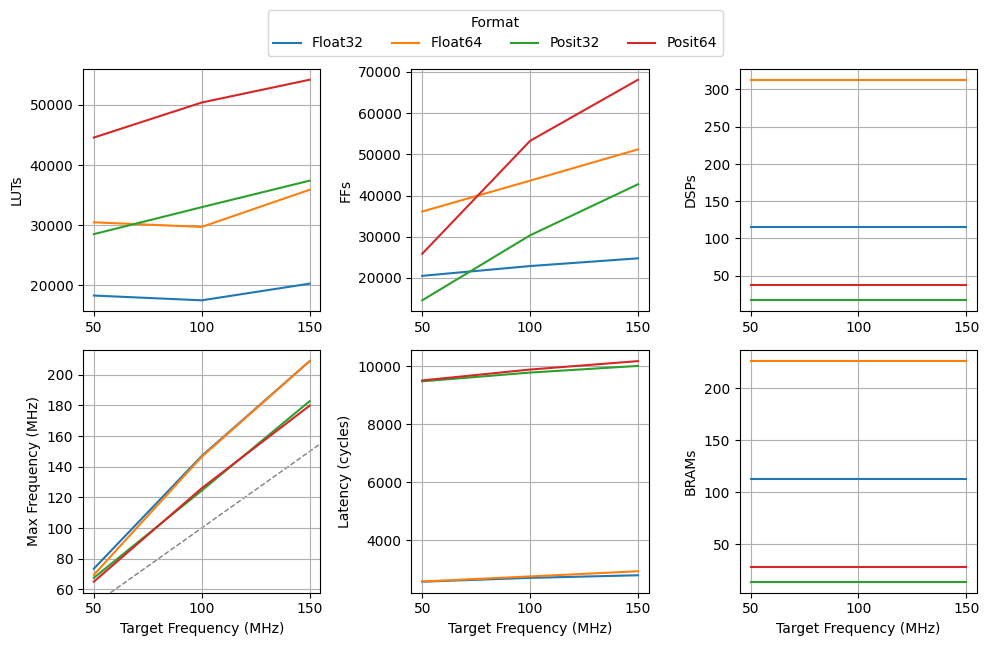

In [6]:
benchmark_name = '3mm'

plot_results(benchmark_name)
plot_results(benchmark_name, all=True)
# plot_results_all(benchmark_name)

### fdtd-2d

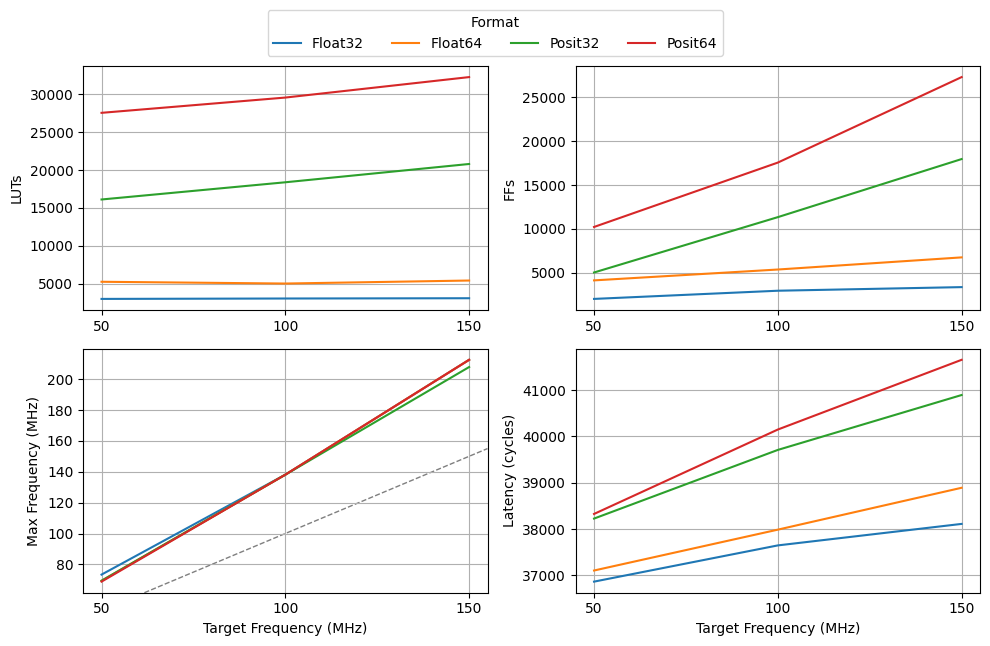

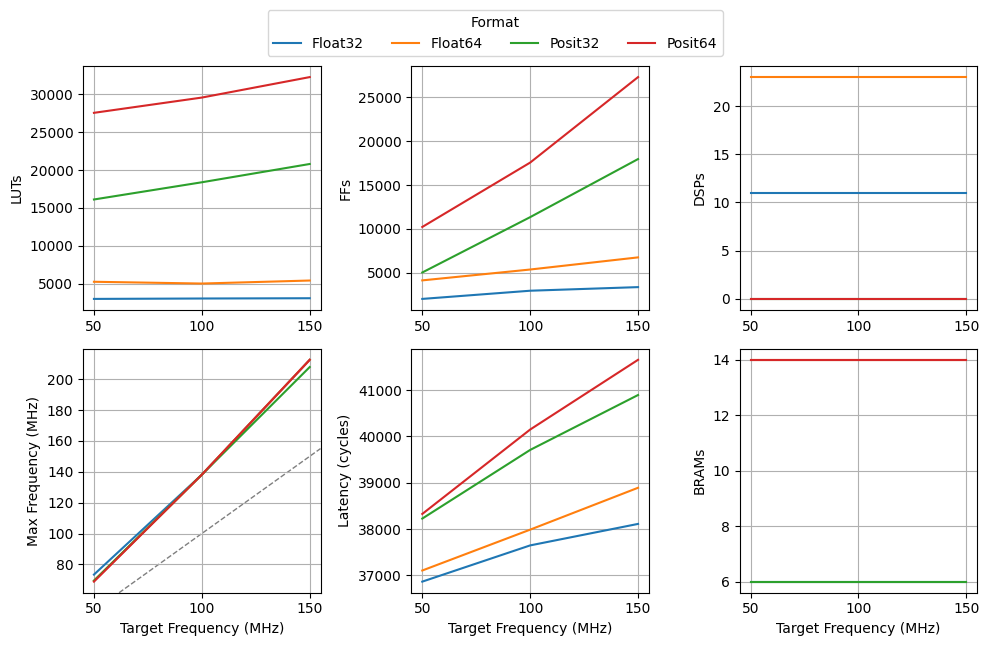

In [7]:
benchmark_name = 'fdtd-2d'

plot_results(benchmark_name)
plot_results(benchmark_name, all=True)
# plot_results_all(benchmark_name)

## Grouped data

In [8]:
period = str(6.66667)
benchmark_size = 'MINI'

formats = ['float32', 'float64',
           'posit32', 'posit64']

resources = []

# BENCHMARKS = ['3mm', 'cholesky', 'covariance', 'durbin', 'fdtd-2d', 'gemm', 'ludcmp', 'seidel-2d']
BENCHMARKS = ['3mm', 'fdtd-2d', 'gemm']


for benchmark_name in BENCHMARKS:
    for format in (formats):
        benchmark_dict = read_accuracy_file(
            '../Vitis_HLS/polybench/' + benchmark_name + '/results.txt', format, period)

        benchmark_dict['Benchmark'] = (benchmark_name)
        benchmark_dict['Format'] = (format.title())
        resources.append(benchmark_dict)


df = pd.DataFrame(resources)

# Columns order
df = df[['Benchmark', 'Format', 'LUTs', 'FFs',
         'DSPs', 'BRAMs', 'Frequency', 'Cycles']]
df.rename(columns={'Frequency': 'Max Frequency (MHz)',
          'Cycles': 'Latency (cycles)'}, inplace=True)
METRICS = ['LUTs', 'FFs', 'DSPs', 'BRAMs',
           'Max Frequency (MHz)', 'Latency (cycles)']
df

# print(df.to_latex())

,Benchmark,Format,LUTs,FFs,DSPs,BRAMs,Max Frequency (MHz),Latency (cycles)
0,3mm,Float32,20272,24747,115,113,208.986416,2791
1,3mm,Float64,35886,51207,313,226,208.986416,2929
2,3mm,Posit32,37398,42726,17,14,182.815356,10015
3,3mm,Posit64,54182,68104,37,28,179.888469,10181
4,fdtd-2d,Float32,3075,3353,11,6,212.494688,38113
5,fdtd-2d,Float64,5413,6747,23,14,212.494688,38893
6,fdtd-2d,Posit32,20801,17971,0,6,207.813799,40895
7,fdtd-2d,Posit64,32275,27328,0,14,212.494688,41655
8,gemm,Float32,5420,6888,38,6,158.252888,19687
9,gemm,Float64,14813,22691,168,12,184.569952,17747


In [9]:
# Print all geometric means

for i, metric in enumerate(METRICS):
    df_aux = df[['Benchmark', 'Format', metric]].pivot(
    index='Benchmark', columns='Format', values=metric)
    g_mean = gmean(df_aux, axis=0)
    print(g_mean)
print(df_aux.columns)

[ 6964.88047836 14223.35449345 21600.7009081  31265.30884163]
[ 8298.82137233 19865.42647564 22114.32955078 34179.28041946]
[ 36.36006973 106.54354718   0.           0.        ]
[15.96345827 33.61031429  7.95811442 16.75543746]
[191.54578215 201.62407043 180.90545883 180.44538591]
[12793.93591157 12644.60464288 20041.89441645 20706.99579445]
Index(['Float32', 'Float64', 'Posit32', 'Posit64'], dtype='object', name='Format')


In [10]:
# Print all geometric means

for i, metric in enumerate(METRICS):
    g_mean = df[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))
    print(g_mean)
    print(g_mean.T[['Float32', 'Posit32', 'Float64', 'Posit64']].values)

TypeError: can't multiply sequence by non-int of type 'str'

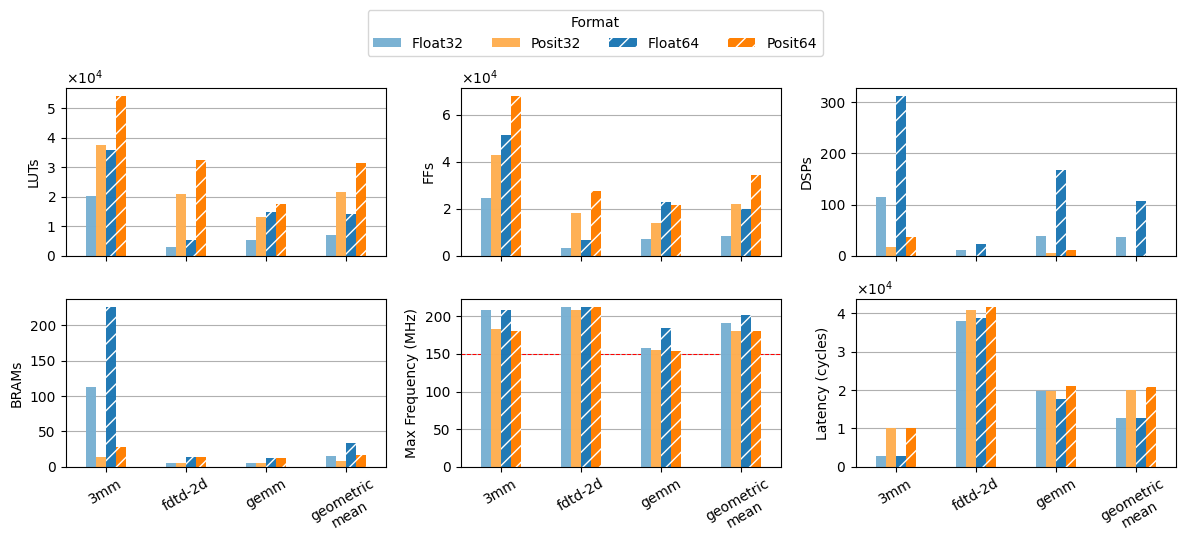

In [ ]:
fig, axs = plt.subplots(2, 3, sharex=True,
                        figsize=(12, 5)
                        )
# colors = ['#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c',
#           '#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c']
colors = ['#79B1D3', '#FEAF53', '#1f78b4', '#ff7f00']
hatches = ([''] * (len(df)//2+2)) + (['//'] * (len(df)//2+2))

plt.rcParams.update({'hatch.color': 'w'})


for i, metric in enumerate(METRICS):
    log_y = metric in ['Cycles'] and False

    # GEOMETRIC MEAN
    # if metric != 'DSPs':
    # g_mean = (df.loc[df['Benchmark'] != 'seidel-2d'])[['Benchmark', 'Format', metric]].groupby('Format').prod().pow(1 / 7)
    g_mean = df[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS)).T[['Float32', 'Posit32', 'Float64', 'Posit64']]
    # if metric == 'DSPs':
    #     g_mean = (df.loc[df['Benchmark'] != 'fdtd-2d'])[['Benchmark', 'Format', metric]].groupby('Format').prod().pow(1 / (len(BENCHMARKS)-1))
    # g_mean = df[['Benchmark', 'Format', metric]].groupby(
    #     'Format', sort=False).prod().pow(1 / len(BENCHMARKS))
    # g_mean = g_mean.rename(columns = {'LUTs':'geometric\nmean'})
    # # g_mean.plot(ax=axs[int(i/3),i%3],
    # #             kind='line')
    # for j, v in enumerate(g_mean.values):
    #     axs[int(i/3),i%3].hlines(v, xmin=-1, xmax=8,
    #                             color = colors[j],
    #                             linestyle=(j, (4, 3, 1, 3)),
    #                             # linestyle='-.',
    #                             linewidth=0.75,
    #                             zorder=2)

    # VALUE BAR PLOT
    m_df = df[['Benchmark', 'Format', metric]].pivot(
        index='Benchmark', columns='Format', values=metric)
    # m_df = m_df[['Float32', 'Float64', 'Posit32', 'Posit64']]
    m_df = m_df[['Float32', 'Posit32', 'Float64', 'Posit64']]
    m_df.loc['geometric\nmean'] = g_mean.values[0]
    ax = m_df.plot(ax=axs[int(i/3), i % 3],
                   # x='Test',
                   kind='bar',
                   stacked=False,
                   logy=log_y,
                   ylabel=metric,
                   color=colors,
                   rot=30,
                   legend=False,
                   zorder=2,
                   width=0.5,
                   alpha=0.99,  # Bug with hatches: https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf
                   # colormap=cmap,
                   # title='Grouped Bar Graph with dataframe'
                   )
    # Set hatches
    bars = ax.patches
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.grid(axis='y', zorder=0.0)
    ax.set_xlabel('')


# Some adjustments
# DSPs plot
# axs[0,2].set_ylim(0,12.4)
# axs[0,2].set_yticks(range(0,14,2))
# Highlight target frequency
# axs[1,1].set_ylim(85,165)
axs[1, 1].axhline(y=150, color='red', linestyle='--',
                  linewidth=0.75, zorder=1.9)
# Y Axis format
axs[1, 2].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
axs[0, 1].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
axs[0, 0].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
# axs[0, 2].set_yscale('log')
# axs[1, 0].set_yscale('log')


# Set global legend
axLine, axLabel = axs[1, 1].get_legend_handles_labels()
fig.legend(axLine, axLabel,
           loc='upper center',
           ncol=6,
           title='Format',
           bbox_to_anchor=(0.5, 1.1)
           )


fig.tight_layout()
plt.savefig("vitis_polybench.pdf", bbox_inches="tight")
plt.show()

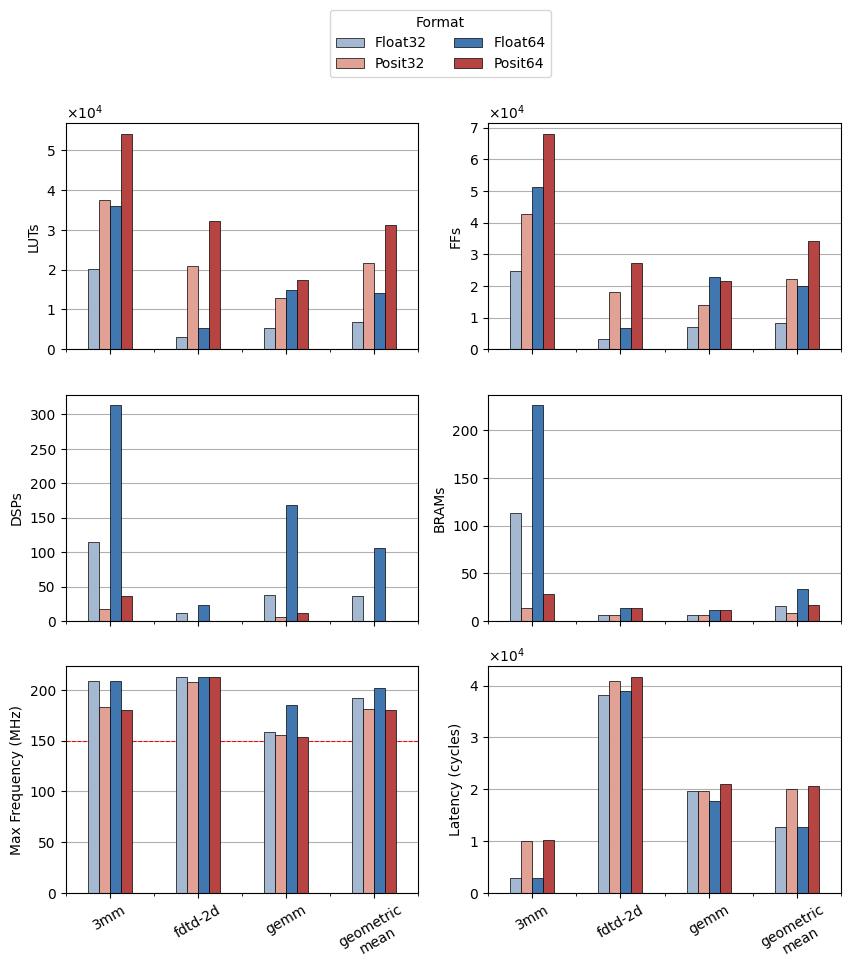

In [11]:
fig, axs = plt.subplots(3, 2, sharex=True,
                        # figsize=(12, 5)
                        )
# colors = ['#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c',
#           '#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c']
# colors = ['#79B1D3', '#FEAF53', '#1f78b4', '#ff7f00']
# colors = ['#95a9cd', '#d29291', '#4573a7', '#aa4744']
colors = ['#a5b8d1', '#e1a295', 
        #   '#b2c285', 
          '#4077b0', '#b54442', 
        #   '#628817'
          ]
hatches = ([''] * (8+len(df)//2+2)) + (['//'] * (len(df)//2+2))

plt.rcParams.update({'hatch.color': 'w'})


for i, metric in enumerate(METRICS):
    log_y = metric in ['Cycles'] and False

    # VALUE BAR PLOT
    m_df = df[['Benchmark', 'Format', metric]].pivot(
        index='Benchmark', columns='Format', values=metric)
    m_df.loc['geometric\nmean'] = gmean(m_df, axis=0).T
    
    m_df = m_df[['Float32', 'Posit32',
                 'Float64', 'Posit64']]
    
    ax = m_df.plot(ax=axs[int(i/2), i % 2],
                   # x='Test',
                   kind='bar',
                   stacked=False,
                   logy=log_y,
                   ylabel=metric,
                   color=colors,
                   rot=30,
                   legend=False,
                   zorder=2,
                   width=0.5,
                   edgecolor='k',
                   linewidth=0.5,
                   alpha=1,  # Bug with hatches: https://stackoverflow.com/questions/5195466/matplotlib-does-not-display-hatching-when-rendering-to-pdf
                   # colormap=cmap,
                   # title='Grouped Bar Graph with dataframe'
                   )
    # Set hatches
    bars = ax.patches
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)

    ax.grid(axis='y', zorder=0.0)
    ax.set_xlabel('')


# Some adjustments
# DSPs plot
# axs[1, 0].set_ylim(0,12.4)
# axs[1, 0].set_yticks(range(0,14,2))
# Highlight target frequency
# axs[2, 0].set_ylim(85,165)
axs[2, 0].axhline(y=150, color='red', linestyle='--',
                  linewidth=0.75, zorder=1.9)
# Y Axis format
axs[2, 1].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
axs[0, 1].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
axs[0, 0].ticklabel_format(axis='y', style='sci',
                           scilimits=(0, 0), useMathText='True')
# axs[0, 2].set_yscale('log')
# axs[1, 0].set_yscale('log')


# Set global legend
axLine, axLabel = axs[1, 1].get_legend_handles_labels()
fig.legend(axLine, axLabel,
           loc='upper center',
           ncol=2,
           title='Format',
           bbox_to_anchor=(0.5, 1.0)
           )


# fig.tight_layout()
fig.set_size_inches(10, 10)
plt.savefig("vitis_polybench.pdf", bbox_inches="tight")
plt.show()

### Comparison

In [50]:
df_vitis = df

In [51]:
def read_bambu_accuracy_file(synthesis_results_file):
    lines = []
    with open(synthesis_results_file) as screen_outputs:
        lines = screen_outputs.readlines()

    # Obtain resources
    resources = dict.fromkeys(
        ['LUTs', 'FFs', 'DSPs', 'BRAMs', 'Frequency', 'Cycles'])
    resources['FFs'] = 0  # incase no registers
    for line in lines:
        if line[:6] == "  Luts":
            resources['LUTs'] = (int(line[29:-1]))
        elif line[:11] == "  Registers":
            resources['FFs'] = (int(line[29:-1]))
        elif line[:6] == "  DSPs":
            resources['DSPs'] = (int(line[29:-1]))
        elif line[:7] == "  BRAMs":
            resources['BRAMs'] = (int(line[29:-1]))
        elif line[:11] == "  Frequency":
            resources['Frequency'] = (float(line[29:-1]))
        elif line[:14] == "  Total cycles":
            resources['Cycles'] = (int(line[29:-7]))

    return resources

In [52]:
period = str(6.66667)
benchmark_size = 'MINI'

formats = ['float32', 'float64',
           'posit32', 'posit64']

resources = []

# BENCHMARKS = ['3mm', 'cholesky', 'covariance', 'durbin', 'fdtd-2d', 'gemm', 'ludcmp', 'seidel-2d']
BENCHMARKS = ['3mm', 'fdtd-2d', 'gemm']


for benchmark_name in BENCHMARKS:
    for format in (formats):
        benchmark_dict = read_bambu_accuracy_file(
            '../Bambu/polybench/' + benchmark_name + '/' + format + '/results_' + str(period) + '_' + benchmark_size + '.txt')

        benchmark_dict['Benchmark'] = (benchmark_name)
        benchmark_dict['Format'] = (format.title())
        resources.append(benchmark_dict)


df_bambu = pd.DataFrame(resources)

# Columns order
df_bambu = df_bambu[['Benchmark', 'Format', 'LUTs',
                     'FFs', 'DSPs', 'BRAMs', 'Frequency', 'Cycles']]
df_bambu.rename(columns={'Frequency': 'Max Frequency (MHz)',
                'Cycles': 'Latency (cycles)'}, inplace=True)
METRICS = ['LUTs', 'FFs', 'DSPs', 'BRAMs',
           'Max Frequency (MHz)', 'Latency (cycles)']
df_bambu

# print(df.to_latex())

,Benchmark,Format,LUTs,FFs,DSPs,BRAMs,Max Frequency (MHz),Latency (cycles)
0,3mm,Float32,3568,2079,2,28,158.654609,573628
1,3mm,Float64,8074,3849,9,56,142.065634,746426
2,3mm,Posit32,4233,2618,2,28,150.920616,724813
3,3mm,Posit64,9186,5394,12,56,146.391451,1135187
4,fdtd-2d,Float32,8989,8069,2,16,106.213489,771404
5,fdtd-2d,Float64,13210,10042,9,32,115.154307,1007680
6,fdtd-2d,Posit32,9265,8518,2,16,111.731844,864295
7,fdtd-2d,Posit64,14081,12147,12,32,113.960114,1303810
8,gemm,Float32,2570,1773,2,12,156.421086,343967
9,gemm,Float64,5495,3436,9,24,142.938822,445417


In [53]:
# df_vitis / df_bambu

df_cmp = df_vitis.copy()

df_cmp[METRICS] = df_vitis[METRICS].divide(df_bambu[METRICS])
# df_cmp[METRICS] = np.log(df[METRICS].divide(df_bambu[METRICS])) # logarithmic change
# df_cmp[METRICS] = (df_vitis[METRICS]-df_bambu[METRICS]
#                    ).divide(df_bambu[METRICS])  # Proportional difference

df_cmp

,Benchmark,Format,LUTs,FFs,DSPs,BRAMs,Max Frequency (MHz),Latency (cycles)
0,3mm,Float32,5.681614,11.903319,57.500000,4.035714,1.317241,0.004866
1,3mm,Float64,4.444637,13.303975,34.777778,4.035714,1.471055,0.003924
2,3mm,Posit32,8.834869,16.320092,8.500000,0.500000,1.211335,0.013817
3,3mm,Posit64,5.898324,12.625881,3.083333,0.500000,1.228818,0.008969
4,fdtd-2d,Float32,0.342085,0.415541,5.500000,0.375000,2.000637,0.049407
5,fdtd-2d,Float64,0.409765,0.671878,2.555556,0.437500,1.845304,0.038597
6,fdtd-2d,Posit32,2.245116,2.109768,0.000000,0.375000,1.859933,0.047316
7,fdtd-2d,Posit64,2.292096,2.249774,0.000000,0.437500,1.864641,0.031949
8,gemm,Float32,2.108949,3.884941,19.000000,0.500000,1.011711,0.057235
9,gemm,Float64,2.695723,6.603900,18.666667,0.500000,1.291251,0.039844


In [54]:
df_bambu[METRICS].divide(df_vitis[METRICS])

,LUTs,FFs,DSPs,BRAMs,Max Frequency (MHz),Latency (cycles)
0,0.176006,0.084010,0.017391,0.247788,0.759162,205.527768
1,0.224990,0.075166,0.028754,0.247788,0.679784,254.839877
2,0.113188,0.061274,0.117647,2.000000,0.825536,72.372741
3,0.169540,0.079202,0.324324,2.000000,0.813790,111.500540
4,2.923252,2.406502,0.181818,2.666667,0.499841,20.239918
5,2.440421,1.488365,0.391304,2.285714,0.541916,25.909032
6,0.445411,0.473986,inf,2.666667,0.537654,21.134491
7,0.436282,0.444489,inf,2.285714,0.536296,31.300204
8,0.474170,0.257404,0.052632,2.000000,0.988425,17.471783
9,0.370958,0.151426,0.053571,2.000000,0.774443,25.098157


In [55]:
for i, metric in enumerate(METRICS):
    g_mean_vitis = df_vitis[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))

    g_mean_bambu = df_bambu[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))

    print(g_mean_vitis)
    print((g_mean_vitis.T['Posit32'] / g_mean_vitis.T['Float32']).values[0],
          (g_mean_vitis.T['Posit64'] / g_mean_vitis.T['Float64']).values[0])
    # print(g_mean_bambu)
    # print(g_mean_vitis / g_mean_bambu)
    print()

                 LUTs
Format               
Float32   6964.880478
Float64  14223.354493
Posit32  21600.700908
Posit64  31265.308842
3.1013742411253222 2.1981670256497834

                  FFs
Format               
Float32   8298.821372
Float64  19865.426476
Posit32  22114.329551
Posit64  34179.280419
2.664755458469463 1.7205409841758161

               DSPs
Format             
Float32   36.360070
Float64  106.543547
Posit32    0.000000
Posit64    0.000000
0.0 0.0

             BRAMs
Format            
Float32  15.963458
Float64  33.610314
Posit32   7.958114
Posit64  16.755437
0.498520701413946 0.498520701413946

         Max Frequency (MHz)
Format                      
Float32           191.545782
Float64           201.624070
Posit32           180.905459
Posit64           180.445386
0.9444502342864763 0.8949595429367999

         Latency (cycles)
Format                   
Float32      12793.935912
Float64      12644.604643
Posit32      20041.894416
Posit64      20706.995794
1.56651514

In [56]:
for i, metric in enumerate(METRICS):
    g_mean_vitis = df_vitis[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))

    g_mean_bambu = df_bambu[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))

    # print(g_mean_vitis)
    # print((g_mean_vitis.T['Posit32']/ g_mean_vitis.T['Float32']).values[0], (g_mean_vitis.T['Posit64']/ g_mean_vitis.T['Float64']).values[0])
    print(g_mean_bambu)
    print((g_mean_bambu.T['Posit32'] / g_mean_bambu.T['Float32']).values[0],
          (g_mean_bambu.T['Posit64'] / g_mean_bambu.T['Float64']).values[0])
    # print(g_mean_vitis / g_mean_bambu)
    print()

                LUTs
Format              
Float32  4352.008983
Float64  8368.605326
Posit32  4998.822427
Posit64  9532.170346
1.1486241058215712 1.139039299143248

                 FFs
Format              
Float32  3098.329819
Float64  5101.999689
Posit32  3698.140805
Posit64  6889.523426
1.193591715894833 1.3503574767123272

         DSPs
Format       
Float32   2.0
Float64   9.0
Posit32   2.0
Posit64  12.0
1.0 1.3333333333333335

             BRAMs
Format            
Float32  17.518077
Float64  35.036153
Posit32  17.518077
Posit64  35.036153
1.0 1.0

         Max Frequency (MHz)
Format                      
Float32           138.136746
Float64           132.731236
Posit32           135.721253
Posit64           134.555549
0.9825137532349635 1.013744411047718

         Latency (cycles)
Format                   
Float32     533920.179979
Float64     694531.682923
Posit32     616922.671550
Posit64     969935.214952
1.1554586147587238 1.396531272510314



In [57]:
g_mean_vitis, g_mean_bambu

(         Latency (cycles)
 Format                   
 Float32      12793.935912
 Float64      12644.604643
 Posit32      20041.894416
 Posit64      20706.995794,
          Latency (cycles)
 Format                   
 Float32     533920.179979
 Float64     694531.682923
 Posit32     616922.671550
 Posit64     969935.214952)

In [58]:
df_cmp[['Benchmark', 'Format', 'LUTs']].groupby(
    'Format', sort=False).prod()  # prod().pow(1 / len(BENCHMARKS))

,LUTs
Format,
Float32,4.098941
Float64,4.909608
Posit32,80.686412
Posit64,35.286841


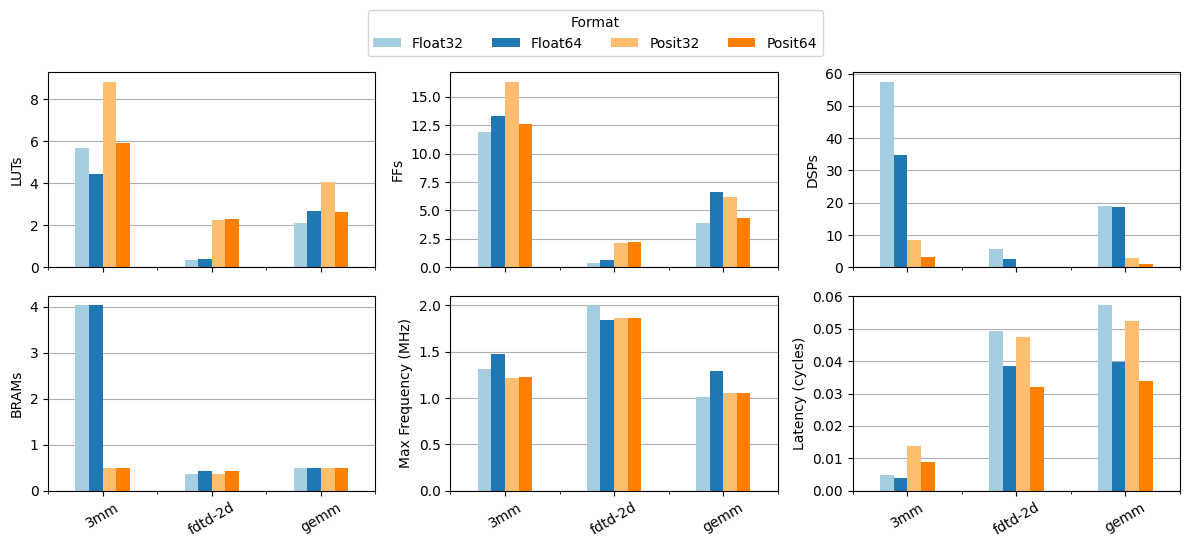

In [59]:
fig, axs = plt.subplots(2, 3, sharex=True,
                        figsize=(12, 5)
                        )
colors = ['#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c',
          '#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c']

for i, metric in enumerate(METRICS):
    log_y = metric in ['Cycles'] and False

    # GEOMETRIC MEAN
    # if metric != 'DSPs':
    # g_mean = (df.loc[df['Benchmark'] != 'seidel-2d'])[['Benchmark', 'Format', metric]].groupby('Format').prod().pow(1 / 7)
    g_mean = df_cmp[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))
    # g_mean = g_mean.rename(columns = {'LUTs':'geometric\nmean'})
    # # g_mean.plot(ax=axs[int(i/3),i%3],
    # #             kind='line')
    # for j, v in enumerate(g_mean.values):
    #     axs[int(i/3),i%3].hlines(v, xmin=-1, xmax=8,
    #                             color = colors[j],
    #                             linestyle=(j, (4, 3, 1, 3)),
    #                             # linestyle='-.',
    #                             linewidth=0.75,
    #                             zorder=2)

    # VALUE BAR PLOT
    m_df = df_cmp[['Benchmark', 'Format', metric]].pivot(
        index='Benchmark', columns='Format', values=metric)
    m_df = m_df[['Float32', 'Float64', 'Posit32', 'Posit64']]
    # m_df.loc['geometric\nmean'] = g_mean.T.values[0]
    ax = m_df.plot(ax=axs[int(i/3), i % 3],
                   # x='Test',
                   kind='bar',
                   stacked=False,
                   logy=log_y,
                   ylabel=metric,
                   color=colors,
                   rot=30,
                   legend=False,
                   zorder=2,
                   width=0.5,
                   # colormap=cmap,
                   # title='Grouped Bar Graph with dataframe'
                   )

    ax.grid(axis='y', zorder=0.0)
    ax.set_xlabel('')


# Some adjustments
# DSPs plot
# axs[0,2].set_ylim(0,12.4)
# axs[0,2].set_yticks(range(0,14,2))
# Highlight target frequency
# axs[1,1].set_ylim(85,165)
# axs[1,1].axhline(y=150, color='red', linestyle='--', linewidth=0.75, zorder=1.9)
# ## Y Axis format
# axs[1,2].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# Cycles plot
# axs[1,2].semilogy()
for i in range(6):
    axs[int(i/3), i % 3].axhline(y=0, color='k',
                                 linestyle='-', linewidth=0.75, zorder=1.9)


# Set global legend
axLine, axLabel = axs[1, 1].get_legend_handles_labels()
fig.legend(axLine, axLabel,
           loc='upper center',
           ncol=6,
           title='Format',
           bbox_to_anchor=(0.5, 1.1)
           )


fig.tight_layout()
# plt.savefig("synth_comparison.pdf", bbox_inches="tight")
plt.show()

In [60]:
metric = 'LUTs'

m = df_vitis[['Benchmark', 'Format', metric]].pivot(
    index='Benchmark', columns='Format', values=metric)

g = df_bambu[['Benchmark', 'Format', metric]].groupby(
    'Format', sort=False).prod().pow(1 / len(BENCHMARKS))

# m[['Float32', 'Float64', 'Posit32', 'Posit64']] -
m - g.T.values[0]

Format,Float32,Float64,Posit32,Posit64
Benchmark,,,,
3mm,15919.991017,27517.394674,32399.177573,44649.829654
fdtd-2d,-1277.008983,-2955.605326,15802.177573,22742.829654
gemm,1067.991017,6444.394674,7957.177573,7944.829654


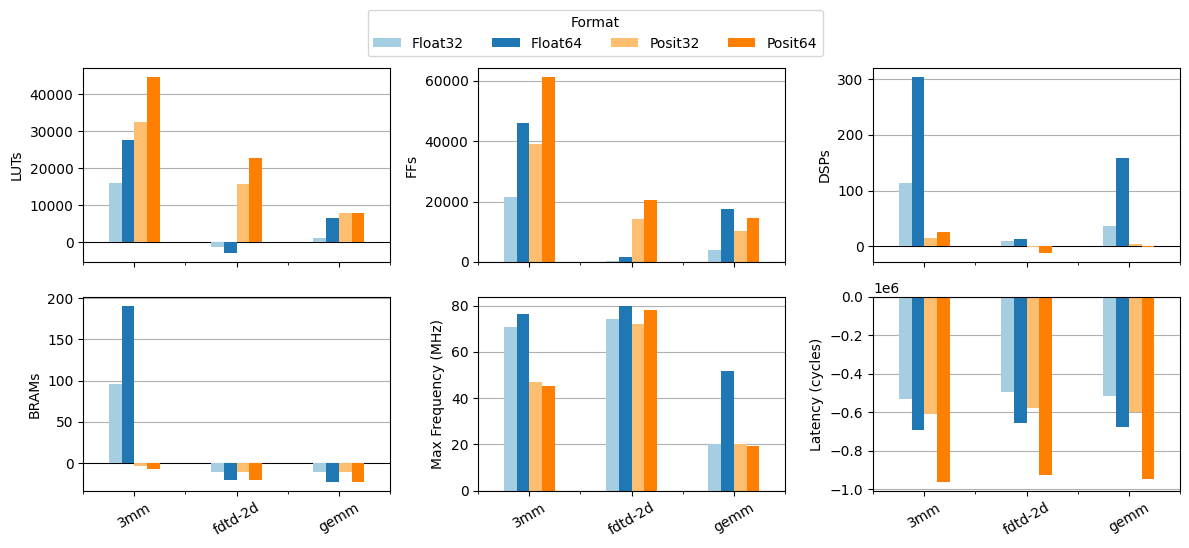

In [61]:
fig, axs = plt.subplots(2, 3, sharex=True,
                        figsize=(12, 5)
                        )
colors = ['#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c',
          '#a6cee3', '#1f78b4', '#fdbf6f', '#ff7f00', '#b2df8a', '#33a02c']

for i, metric in enumerate(METRICS):
    log_y = metric in ['Cycles'] and False

    # GEOMETRIC MEAN
    # if metric != 'DSPs':
    # g_mean = (df.loc[df['Benchmark'] != 'seidel-2d'])[['Benchmark', 'Format', metric]].groupby('Format').prod().pow(1 / 7)
    g_mean = df_bambu[['Benchmark', 'Format', metric]].groupby(
        'Format', sort=False).prod().pow(1 / len(BENCHMARKS))
    # g_mean = g_mean.rename(columns = {'LUTs':'geometric\nmean'})
    # # g_mean.plot(ax=axs[int(i/3),i%3],
    # #             kind='line')
    # for j, v in enumerate(g_mean.values):
    #     axs[int(i/3),i%3].hlines(v, xmin=-1, xmax=8,
    #                             color = colors[j],
    #                             linestyle=(j, (4, 3, 1, 3)),
    #                             # linestyle='-.',
    #                             linewidth=0.75,
    #                             zorder=2)

    # VALUE BAR PLOT -- DEVIATION: difference between the observed value and geometric mean of Bambu
    m_df = df_vitis[['Benchmark', 'Format', metric]].pivot(
        index='Benchmark', columns='Format', values=metric)
    m_df = m_df[['Float32', 'Float64', 'Posit32', 'Posit64']]
    m_df -= g_mean.T.values[0]
    # m_df.loc['geometric\nmean'] = g_mean.T.values[0]
    ax = m_df.plot(ax=axs[int(i/3), i % 3],
                   # x='Test',
                   kind='bar',
                   stacked=False,
                   logy=log_y,
                   ylabel=metric,
                   color=colors,
                   rot=30,
                   legend=False,
                   zorder=2,
                   width=0.5,
                   # colormap=cmap,
                   # title='Grouped Bar Graph with dataframe'
                   )

    ax.grid(axis='y', zorder=0.0)
    ax.set_xlabel('')


# Some adjustments
# DSPs plot
# axs[0,2].set_ylim(0,12.4)
# axs[0,2].set_yticks(range(0,14,2))
# Highlight target frequency
# axs[1,1].set_ylim(85,165)
# axs[1,1].axhline(y=150, color='red', linestyle='--', linewidth=0.75, zorder=1.9)
# ## Y Axis format
# axs[1,2].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# axs[0,1].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# axs[0,0].ticklabel_format(axis='y', style='sci', scilimits=(0, 0), useMathText='True')
# Cycles plot
# axs[1,2].semilogy()
for i in range(6):
    axs[int(i/3), i % 3].axhline(y=0, color='k',
                                 linestyle='-', linewidth=0.75, zorder=1.9)


# Set global legend
axLine, axLabel = axs[1, 1].get_legend_handles_labels()
fig.legend(axLine, axLabel,
           loc='upper center',
           ncol=6,
           title='Format',
           bbox_to_anchor=(0.5, 1.1)
           )


fig.tight_layout()
# plt.savefig("synth_comparison.pdf", bbox_inches="tight")
plt.show()